In [23]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import pickle

# ML imports
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy import optimize, linalg
import scipy

# custom imports
import encoding_tools as encoding
import chimera_tools as chimera
import GP_tools as GP

# import scipy
import seaborn as sns

# define plotting settings
sns.set_context("paper")
sns.set_style("white")

# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'legend.fontsize': 12})
sns.color_palette('colorblind')
plt.close('all')

## Convert data to usable from

In [60]:
# load contact information
path_inputs = 'inputs/'
path_outputs = 'outputs/'
fname_1 = path_inputs + 'lit_alignment_and_contacts_pro2.pkl'

# load the contact map
with open(fname_1, 'rb') as f:
    ss, contacts = pickle.load(f)
    
# only use the first three parents
ss = [i[0:3] for i in ss]

# load data
df_data = pd.read_csv(path_inputs+'Ephys_data_formatted.csv')

# load library files
file_c = path_inputs + 'shmetis_c_10_21_0/chimeras.output'
file_n = path_inputs + 'shmetis_n_10_21_0/chimeras.output'

# add sequence information to dataframe based on chimera code
df_data = chimera.chimera_code2seq_convert(file_c,file_n,df_data)

# select the property of interest
property_ = 'green_norm'

# test data only includes gen 10
df_test_data = df_data[df_data.gen == 10]

# remove ChR_29_10 & ChR_30_10 for kinetics and spectra because currents too low for accurate measurements
if property_ == 'green_norm' or property_ == 'kinetics_off':
    df_test_data = df_test_data[df_test_data.chimera != 'ChR_29_10']
    df_test_data = df_test_data[df_test_data.chimera != 'ChR_30_10']

# training data excludes test data (gen 10)
df_data = df_data[df_data.gen != 10]

# make a seperate dataframe for the selected property
df_select = pd.DataFrame()
df_select['prop'] = df_data[str(property_)]
df_select['seq'] = df_data['seq']
df_select['block_k'] = df_data['block_k']
df_select['chimera'] = df_data['chimera']
df_select.dropna(inplace=True)

# normalize training data
log_data = np.log(df_select.prop.values)
y = (log_data - np.mean(log_data))/np.std(log_data)
seq = df_select.seq.values

# make a seperate dataframe for the selected property for test set
df_select_test = pd.DataFrame()
df_select_test['prop'] = df_test_data[str(property_)]
df_select_test['seq'] = df_test_data['seq']
df_select_test['block_k'] = df_test_data['block_k']
df_select_test['chimera'] = df_test_data['chimera']
df_select_test.dropna(inplace=True)

# normalize test data
log_data_test = np.log(df_select_test.prop.values)
y_true_test = (log_data_test - np.mean(log_data))/np.std(log_data)
seq_test = df_select_test.seq.values

## Encodings

In [62]:
# one_hot_encode based on sequence & structure
X = encoding.one_hot_(df_select['seq'].values, ss, contacts)
X = np.array(X)

# also encode the test sequences
X_true_test = encoding.one_hot_(df_select_test['seq'].values, ss, contacts)
X_true_test = np.array(X_true_test)

## Train on split training data

My_prams 0.00370910128433 35.1997129851
My_prams 0.0116605002007 38.8321089386
My_prams 0.0112100206341 38.3838677639
My_prams 0.0115593276868 39.5988877615
My_prams 0.0120147731918 39.2287735152
My_prams 0.0134866805685 38.18809169
My_prams 0.0126215508049 39.4427661149
My_prams 0.0126264993646 41.0852897869
My_prams 0.0114873507237 37.8204832746
My_prams 0.00581142999157 36.173948952
My_prams 0.0112712159906 37.9586018417
My_prams 0.013873204946 39.1708901412
My_prams 0.00990387390743 39.3931983434
My_prams 0.0122464569059 38.7790340699
My_prams 0.0127733110224 39.6328449652
My_prams 0.0114309160565 36.9354413865
My_prams 0.00923477709915 37.9296976125
My_prams 0.0107747172447 39.2588132437
My_prams 0.0131330196339 38.3810762363
My_prams 0.0124005735801 38.7039265844
R^2 = 0.79
R = 0.89


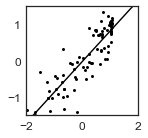

In [63]:
from sklearn.model_selection import KFold # import KFold

kf = KFold(n_splits=20) # Define the split
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

mu_s = []
var_s = []
y_s = []
prams_test2 = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    
    log_data_train, log_data_test = log_data[train_index], log_data[test_index]
    
    y_train = (log_data_train - np.mean(log_data_train))/np.std(log_data_train)
    y_test = (log_data_test - np.mean(log_data_train))/np.std(log_data_train)
    
    initial_guess = [0.1,10]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X_train,y_train), method='L-BFGS-B')#,
        
    print('My_prams ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x)[1]))

    
    # next set of hyper prams 
    prams_me = [np.exp(result.x[0])**2, np.exp(result.x[1])]
    
    # next used trained GP model to predict on test data
    mu, var = GP.predict_GP(X_train, y_train, X_test, prams_me)
    mu_s.append(mu)
    var_s.append(var)
    y_s.append(y_test)

# reformat all
y_s_all = [j for i in y_s for j in i]
mu_s_all = [j for i in mu_s for j in i]

# plot results
plt.figure('My GP test set evaluation2', figsize=(2, 2))
plt.plot(y_s_all, mu_s_all, 'o', color='k', ms=3)
plt.ylim([-1.5, 1.5])
plt.xlim([-2, 2])

# calc correlation 
measured = y_s_all
predicted = mu_s_all

par = np.polyfit(measured, predicted, 1, full=True)
slope=par[0][0]
intercept=par[0][1]

# calc correlation 
variance = np.var(predicted)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(measured, predicted)])
Rsqr = np.round(1-residuals/variance, decimals=2)
print('R^2 = %0.2f'% Rsqr)
print('R = %0.2f'% np.sqrt(Rsqr))

plt.plot([-2, 2], [slope*-2+intercept, slope*2+intercept], '-', color='k')
plt.show()
plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV.pdf', bbox_inches='tight', transparent=True)

## Evaluate on whole training set

My_prams 0.0108294934491 38.5362684851
full training set
R^2 = 0.98
R = 0.99


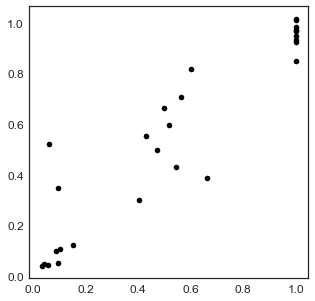

true test set
R^2 = 0.87
R = 0.93


In [64]:
# test the optimization of the hyp-prams
initial_guess = [0.01,10]

# take the log of the initial guess for optimiziation 
initial_guess_log = np.log(initial_guess)

# optimize to fit model
result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')#,
                                    #bounds=bnds)
        
print('My_prams ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x)[1]))
        
# next set of hyper prams 
final_prams = [np.exp(result.x[0])**2, np.exp(result.x[1])]
    
# next use trained GP model to predict full test set
mu, var = GP.predict_GP(X, y, X, final_prams)
mu_true_test, var_true_test = GP.predict_GP(X, y, X_true_test, final_prams)

# calculate correlation
variance = np.var(mu)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y, mu)])
Rsqr = np.round(1-residuals/variance, decimals=2)
print('full training set')
print('R^2 = %0.2f'% Rsqr)
print('R = %0.2f'% np.sqrt(Rsqr))

# convert the true test predications and y back to unnormalized data
y_test_real = np.exp(y_true_test*np.std(log_data)  + np.mean(log_data))
mu_test_real = np.exp(mu_true_test*np.std(log_data)  + np.mean(log_data))

if property_ != 'kinetics_off':
    # plot and measure correlation
    plt.figure('True test', figsize=(5, 5))
    plt.plot(y_test_real, mu_test_real, 'o', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel.pdf', bbox_inches='tight', transparent=True)
    par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    plt.show()
    
    # coefficient of determination, plot text
    variance = np.var(mu_test_real)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y_test_real, mu_test_real)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    print('true test set')
    print('R^2 = %0.2f'% Rsqr)
    print('R = %0.2f'% np.sqrt(Rsqr))
    
elif property_ == 'kinetics_off':
    # plot and measure correlation
    plt.figure('True test', figsize=(5, 5))
    plt.plot(np.log10(y_test_real), np.log10(mu_test_real), 'o', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel.pdf', bbox_inches='tight', transparent=True)
    par = np.polyfit(np.log10(y_test_real), np.log10(mu_test_real), 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    plt.show()

    # coefficient of determination, plot text
    variance = np.var(np.log10(mu_test_real))
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(np.log10(y_test_real), np.log10(mu_test_real))])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    print('true test set')
    print('R^2 = %0.2f'% Rsqr)
    print('R = %0.2f'% np.sqrt(Rsqr))
    plt.savefig(path_outputs + str(property_)+'_matern_kernel.pdf', bbox_inches='tight', transparent=True)

# export csv with predicted values
df_select_test['y'] = y_true_test
df_select_test['mu'] = mu_true_test
df_select_test['y_real'] = y_test_real
df_select_test['mu_real'] = mu_test_real

df_select_test.to_csv(path_outputs+ '/matern_kernel_gen10_'+str(property_)+'.csv')